# Movie Analysis for Microsoft's New Movie Studio

## Overview
This project analyzes various movie datasets to provide actionable insights for Microsoft's new movie studio. The goal is to identify key factors that contribute to a film's success, helping Microsoft make data-driven decisions on what types of films to produce.

## Business Understanding
**Stakeholder:** Microsoft's new movie studio.

**Business Problem:** Microsoft wants to enter the movie production market but lacks experience in creating films. They need insights into the types of movies that are currently performing well at the box office to inform their production strategy.

**Key Business Questions:**
1. **What genres are most profitable?**
2. **Which movie attributes correlate with higher box office returns?**
3. **How do critical and audience ratings impact a movie's financial success?**

## Data Understanding
The analysis uses data from multiple sources:
- **Box Office Mojo (bom.movie_gross.csv):** Contains box office data.
- **IMDB (im.db):** SQLite database with detailed movie information and ratings.
- **The Movie Database (tmdb.movies.csv):** Contains vote information.
- **The Numbers (tn.movie_budgets.csv):** Contains information about production budget, and gross revenue information.

## 1. Exploring the Data
This section delves into our datasets to gain a deeper understanding of their contents. By examining the features present in each dataset, we aim to discern how these attributes might influence the questions we seek to answer.

In [1]:
# import the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sqlite3
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Box Office Mojo (bom.movie_gross.csv)

In [2]:
#Load the dataset
df_bom = pd.read_csv('data/bom.movie_gross.csv')
df_bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
# investigate null values
df_bom.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [5]:
df_bom['foreign_gross'] = df_bom['foreign_gross'].str.replace(',', '').astype(float)

In [6]:
#replace nulls with 0
df_bom.fillna(0, inplace=True)
df_bom.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

### IMDB (imdb dataset)

In [7]:
#create connection
conn = sqlite3.connect('data/im.db')

#the tables in the database
q = """
SELECT *
FROM sqlite_master
WHERE type='table'
"""
tables = list(pd.read_sql(q, conn)['name'])

In [8]:
#load tables
def load_table(name):
    q = f"""
    SELECT *
    FROM {name}
    """
    
    return pd.read_sql(q, conn)

#load the columns of the tables:
def load_columns(name):
    return f"{name}:{list(load_table(name).columns)}"
    
for table in tables:
    print(load_columns(table))

movie_basics:['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']
directors:['movie_id', 'person_id']
known_for:['person_id', 'movie_id']
movie_akas:['movie_id', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'is_original_title']
movie_ratings:['movie_id', 'averagerating', 'numvotes']
persons:['person_id', 'primary_name', 'birth_year', 'death_year', 'primary_profession']
principals:['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters']
writers:['movie_id', 'person_id']


In [9]:
#Create a dataframe with features that we will use: 
q = """
SELECT DISTINCT
    m.primary_title,
    m.start_year,
    m.runtime_minutes,
    m.genres,
    p.primary_name AS director_name,
    r.averagerating,
    r.numvotes
FROM 
    movie_basics m
JOIN 
    directors d ON m.movie_id = d.movie_id
JOIN 
    persons p ON d.person_id = p.person_id
LEFT JOIN 
    movie_ratings r ON m.movie_id = r.movie_id;

"""

df_db = pd.read_sql(q, conn)

In [10]:
df_db.head()

,primary_title,start_year,runtime_minutes,genres,director_name,averagerating,numvotes
0,Sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail,7.0,77.0
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",Mani Kaul,7.2,43.0
2,The Other Side of the Wind,2018,122.0,Drama,Orson Welles,6.9,4517.0
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",Hrishikesh Mukherjee,6.1,13.0
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",Raoul Ruiz,6.5,119.0


### The Movie Database(tmdb.movies.csv)

In [11]:
#Load the dataset
df_tmd = pd.read_csv('data/tmdb.movies.csv')

#View the first few columns
df_tmd.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [12]:
df_tmd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [13]:
#Investigate null
df_tmd.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

### The Numbers Dataset(tn.movie_budgets.csv)

In [14]:
#Load the data frame
df_tn = pd.read_csv('data/tn.movie_budgets.csv')
df_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [15]:
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [16]:
#change data types accordingly
df_tn['production_budget'] = df_tn['production_budget'].str.replace('$','').str.replace(",",'').astype(float)
df_tn['domestic_gross'] = df_tn['domestic_gross'].str.replace('$','').str.replace(",",'').astype(float)
df_tn['worldwide_gross'] = df_tn['worldwide_gross'].str.replace('$','').str.replace(",",'').astype(float)


In [17]:
#Investigate null
df_tn.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

## 2. Genre Analysis

Understanding which movie genres are most profitable is essential for strategic planning in the film industry. By identifying trends in genre popularity and profitability, Microsoft's new movie studio can make informed decisions about the types of films to produce. In this section, we will analyze the genres of movies in our dataset to determine:

- **Which genres consistently perform well at the box office.**
- **The average box office returns for each genre.**

### The Most Produced Genres

Understanding which genres are most frequently produced can provide insight into industry trends and audience preferences. By analyzing the frequency of each genre, we can identify which types of movies are most common and possibly why they are favored by filmmakers and studios.

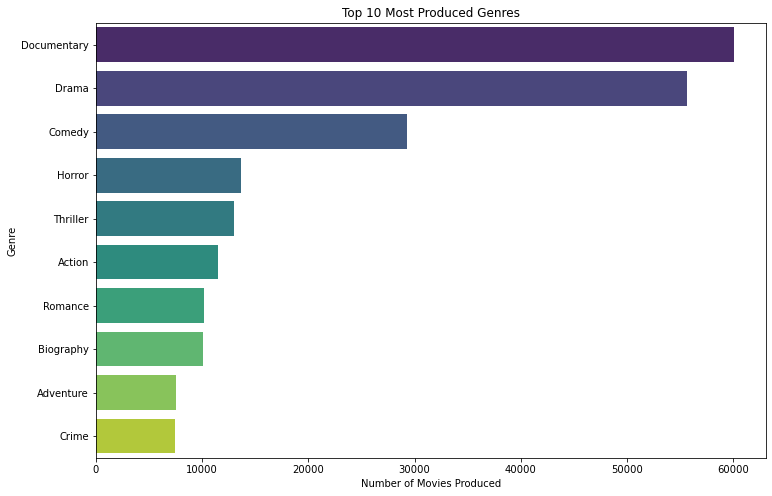

In [18]:
# Split the genres into lists
genres_series = df_db['genres'].str.split(',').dropna()

# Flatten the list of lists and count occurrences of each genre
genres_flat = [genre for sublist in genres_series for genre in sublist]
genre_counts = Counter(genres_flat)

# Convert the Counter object to a DataFrame for easy plotting
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count'])

# Get the top 10 most produced genres
top_genres = genre_counts_df.nlargest(10, 'count')

# Plot the top 10 most produced genres
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='genre', data=top_genres, palette='viridis')
plt.title('Top 10 Most Produced Genres')
plt.xlabel('Number of Movies Produced')
plt.ylabel('Genre')
plt.show()

### Genre Profitability Analysis

In this section, we aim to identify which genres are the most profitable by analyzing their average box office gross. Understanding genre profitability will help Microsoft's new movie studio make informed decisions about which genres to invest in.

#### Methodology

1. **Data Preparation:** We merged the box office data with the genre information.
2. **Calculate Average Gross:** For each genre, we computed the average box office gross.
3. **Visualization:** We plotted the average gross for each genre to highlight the most profitable ones.

#### Results

The following analysis reveals the genres that tend to generate the highest average box office returns. This insight will guide strategic decisions in genre selection for future productions.

Text(0, 0.5, 'Genre')

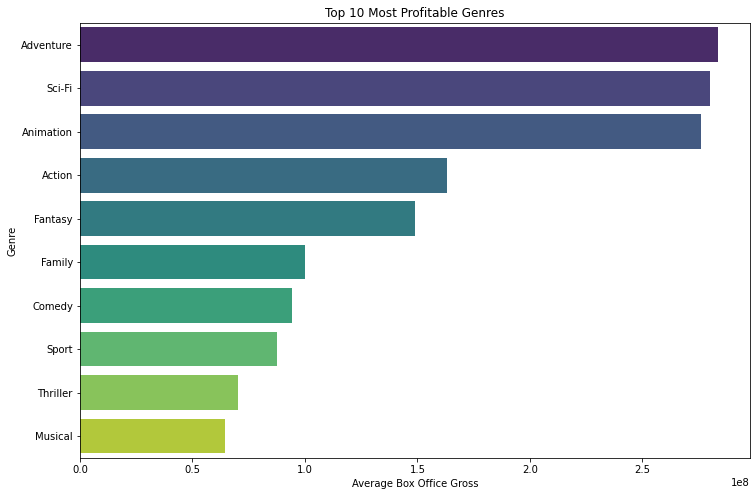

In [19]:
# Merge DataFrames on primary_title and title
df = pd.merge(df_db, df_bom, left_on='primary_title', right_on='title')

# Split genres into lists and drop rows with missing genres
df['genres_list'] = df['genres'].str.split(',').dropna()

# Explode the genres into separate rows
df = df.explode('genres_list')

df['total_gross'] = df['domestic_gross'] + df['foreign_gross']

# Calculate average box office gross for each genre
genre_gross = df.groupby('genres_list')['total_gross'].mean().reset_index()

# Rename columns for clarity
genre_gross.columns = ['genre', 'average_gross']

# Get the top 10 most profitable genres
top_profitable_genres = genre_gross.nlargest(10, 'average_gross')

# Plot the top 10 most profitable genres
plt.figure(figsize=(12, 8))
sns.barplot(x='average_gross', y='genre', data=top_profitable_genres, palette='viridis')
plt.title('Top 10 Most Profitable Genres')
plt.xlabel('Average Box Office Gross')
plt.ylabel('Genre')